In this project we'll build a model to predict stock volatility for SSL,
Sasol Limited, is a South African-based global energy and chemical company known for its pioneering role in converting coal and gas into liquid fuels. Established in 1950 and headquartered in Sandton, Johannesburg, Sasol has grown into one of Africa’s largest industrial giants. The company operates through two primary segments: energy and chemicals, producing everything from synthetic fuels to plastics, fertilizers, and detergents. Sasol is notable for its innovative technologies, particularly in Fischer-Tropsch synthesis, which allows it to turn raw natural resources into high-value products. Listed on both the Johannesburg Stock Exchange (SOL) and the New York Stock Exchange (SSL), Sasol plays a significant role in the South African economy and exports to markets across the globe. Despite facing environmental and financial challenges in recent years, the company continues to adapt by shifting focus toward sustainability and reducing its carbon footprint.

In [3]:
# importing libraries
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model

Next we Create a URL to get all the stock data for ssl ("ssl") from AlphaVantage in JSON format

In [ ]:
ticker = "SSL"
output_size = "full"
data_type = "json"

url = (
   " https://www.alphavantage.co/query?"
    "function=TIME_SERIES_DAILY&"
    "apikey= <your_api_key>&"    #Please replace '<your_api_key>' with your actual Alpha Vantage API key to access the data."
    f"symbol={ticker}&"
    f"outputsize={output_size}&"
    f"datatype={data_type}&"
)
print("url type:", type(url))
url

In [6]:
# We create an HTTP request for the URL
response = requests.get(url=url)

We can use the dir function to get a list of all the attributes and methods available—and as you’ll notice, there’s quite a lot to explore! But for now, let’s zoom in on just one: status_code.
The status_code attribute is especially useful. Whenever you send a request to a URL, the server responds with an HTTP status code, and you can access that code directly using status_code. Let’s check what response we get from our request.

In [8]:
dir(response)

['__attrs__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_content',
 '_content_consumed',
 '_next',
 'apparent_encoding',
 'close',
 'connection',
 'content',
 'cookies',
 'elapsed',
 'encoding',
 'headers',
 'history',
 'is_permanent_redirect',
 'is_redirect',
 'iter_content',
 'iter_lines',
 'json',
 'links',
 'next',
 'ok',
 'raise_for_status',
 'raw',
 'reason',
 'request',
 'status_code',
 'text',
 'url']

In [9]:
response_code = response.status_code
response_code
# A 200 status code means the request was successful—everything worked as expected if not we check our previous code for errors

200

Next we create a DataFrame df_ssl with all the stock data for SSL

In [11]:
response_data = response.json()
response_data.keys()

dict_keys(['Meta Data', 'Time Series (Daily)'])

In [12]:
# We access the value linked to the "Time Series (Daily)" key and store it in the variable stock_data
stock_data = response_data["Time Series (Daily)"]
df_ssl = pd.DataFrame.from_dict(stock_data, orient="index", dtype=float)
df_ssl.head()

,1. open,2. high,3. low,4. close,5. volume
2025-04-09,2.86,3.290,2.7800,3.25,3153810.0
2025-04-08,3.10,3.120,2.8700,2.93,2286104.0
2025-04-07,3.12,3.310,3.0225,3.12,2889367.0
2025-04-04,3.28,3.310,3.1200,3.23,5297434.0
2025-04-03,3.68,3.805,3.5600,3.58,3659657.0


It appears that the index for df_ssl is missing some entries for certain days. To fix this, we’ll need to convert the dates to the correct data type and adjust the header format. Specifically, we should create a proper DatetimeIndex for the dates.

In [14]:
# Convert `df_ssl` index to `DatetimeIndex`
df_ssl.index = pd.to_datetime(df_ssl.index)

# Give index name as "date"
df_ssl.index.name = "date"

# Remove the numbering from `df_ssl` column names
df_ssl.columns = [c.split(". ")[1] for c in df_ssl.columns]

df_ssl.head()

,open,high,low,close,volume
date,,,,,
2025-04-09,2.86,3.290,2.7800,3.25,3153810.0
2025-04-08,3.10,3.120,2.8700,2.93,2286104.0
2025-04-07,3.12,3.310,3.0225,3.12,2889367.0
2025-04-04,3.28,3.310,3.1200,3.23,5297434.0
2025-04-03,3.68,3.805,3.5600,3.58,3659657.0


In [15]:
# We calculate for return
df_ssl["return"] = df_ssl["close"].pct_change() * 100
df_ssl.head()

,open,high,low,close,volume,return
date,,,,,,
2025-04-09,2.86,3.290,2.7800,3.25,3153810.0,NaN
2025-04-08,3.10,3.120,2.8700,2.93,2286104.0,-9.846154
2025-04-07,3.12,3.310,3.0225,3.12,2889367.0,6.484642
2025-04-04,3.28,3.310,3.1200,3.23,5297434.0,3.525641
2025-04-03,3.68,3.805,3.5600,3.58,3659657.0,10.835913


In [16]:
# We drop NAN values
df_ssl.dropna(inplace=True)
df_ssl.head()

,open,high,low,close,volume,return
date,,,,,,
2025-04-08,3.10,3.120,2.8700,2.93,2286104.0,-9.846154
2025-04-07,3.12,3.310,3.0225,3.12,2889367.0,6.484642
2025-04-04,3.28,3.310,3.1200,3.23,5297434.0,3.525641
2025-04-03,3.68,3.805,3.5600,3.58,3659657.0,10.835913
2025-04-02,4.20,4.200,4.1050,4.14,595706.0,15.642458


In [17]:
df_ssl = df_ssl.head(2000)
df_ssl.shape

(2000, 6)

In [18]:
# We sort the index
df_ssl.sort_index(ascending=True, inplace=True)
df_ssl.head()

,open,high,low,close,volume,return
date,,,,,,
2017-04-26,30.82,31.445,30.7000,31.01,325203.0,1.108575
2017-04-27,30.50,31.000,30.3600,30.67,273240.0,0.491481
2017-04-28,30.79,30.810,30.4800,30.52,255932.0,0.493908
2017-05-01,30.50,30.520,30.3200,30.37,162284.0,-2.158505
2017-05-02,31.03,31.260,30.8997,31.04,530391.0,-0.257069


In [19]:
y_ssl = df_ssl['return']
y_ssl.head()

date
2017-04-26    1.108575
2017-04-27    0.491481
2017-04-28    0.493908
2017-05-01   -2.158505
2017-05-02   -0.257069
Name: return, dtype: float64

Now we have our series we calculate daily and annual volatility for y_ssl.

In [21]:
ssl_daily_volatility = y_ssl.describe()["std"]
print("SSL Daily Volatility:", ssl_daily_volatility)

ssl_annual_volatility = ssl_daily_volatility * np.sqrt(252)
print("SSL Annual Volatility:", ssl_annual_volatility)

SSL Daily Volatility: 4.22896941237317
SSL Annual Volatility: 67.13280820343019


Wow the daily volatility of SSL is 4.23%, which translates to an annual volatility of 67.13%, indicating a high level of price fluctuation over the year, lest check the rolling vaolatility in window of 30

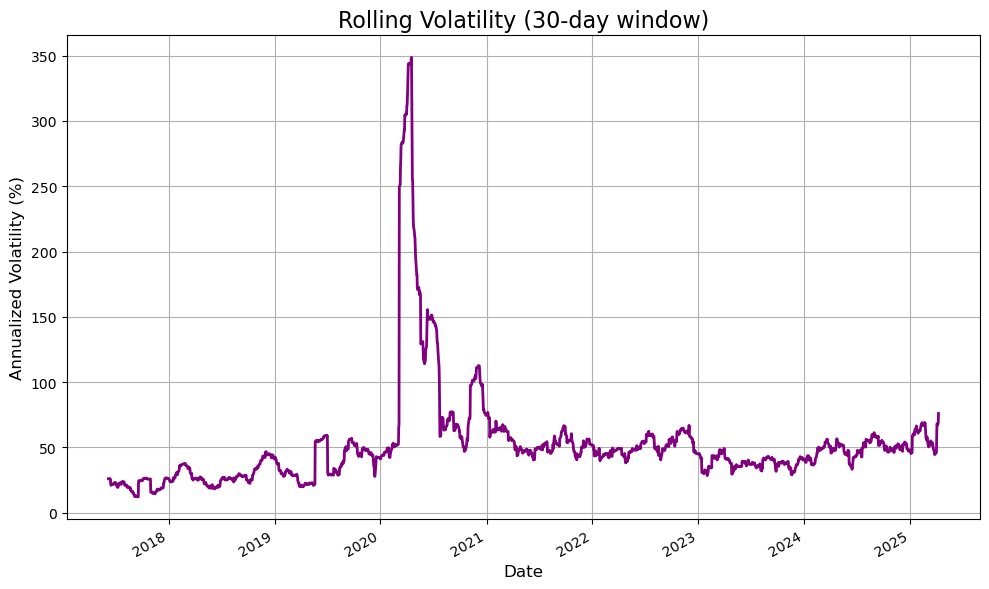

In [23]:
# Define the rolling window (e.g., 30 days)
window = 30

# Calculate rolling volatility
rolling_volatility = df_ssl['return'].rolling(window=window).std() * (252**0.5)  # Annualized volatility

# Plotting with improvements
plt.figure(figsize=(10, 6))
rolling_volatility.plot(color='purple', lw=2)
plt.title('Rolling Volatility (30-day window)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Annualized Volatility (%)', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

Okay from the chart the rolling volatility chart shows a significant spike in early 2020, where annualized volatility surged above 350%, likely reflecting the extreme market uncertainty probably caused by the COVID-19 pandemic. Following this peak, volatility gradually declined and stabilized between 50% and 70% from 2021 through early 2025, with occasional moderate increases. The computed daily volatility is approximately 4.23%, which translates to an annualized volatility of around 70%, consistent with the more stable period shown in the later part of the chart. The data reflects a sharp volatility shock in 2020 followed by a return to relatively steady market conditions, now lets do a time plot against y_ssl just for EDA purposes 'smiles'

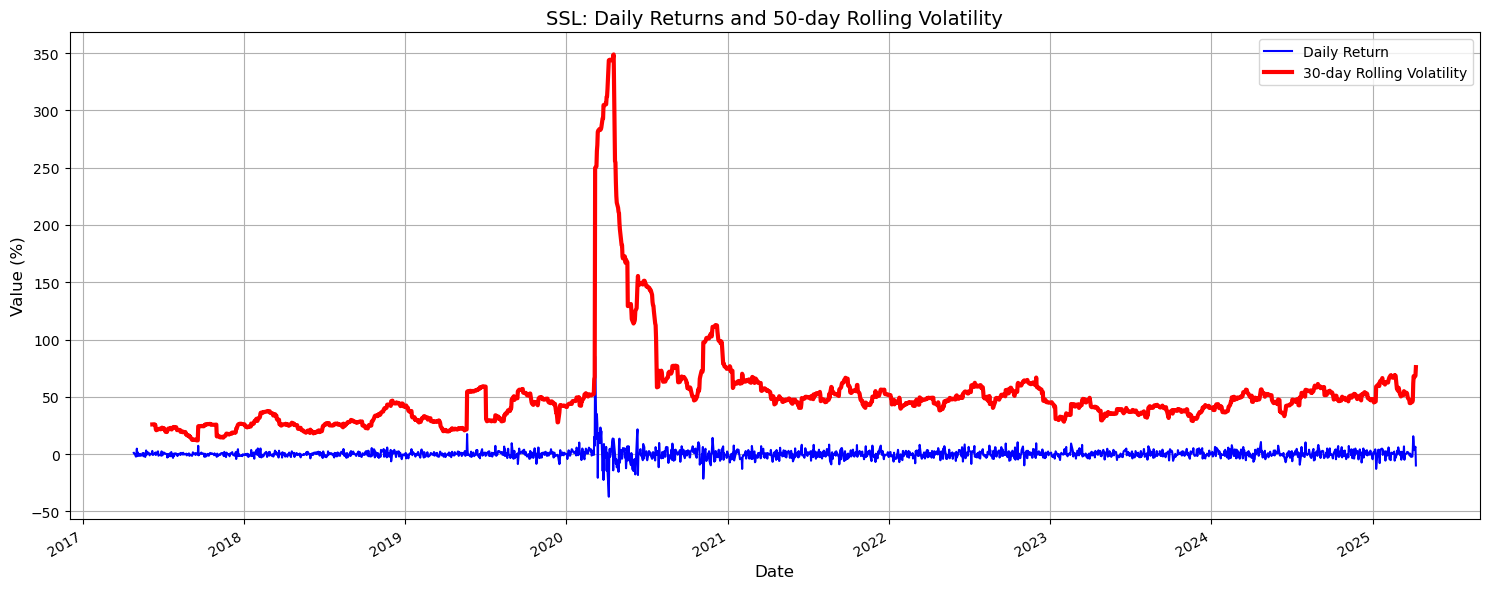

In [25]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the daily returns for SSL
y_ssl.plot(ax=ax, label="Daily Return", color='blue')

# Plot the 30-day rolling volatility for SSL
rolling_volatility.plot(ax=ax, label="30-day Rolling Volatility", color='red', linewidth=3)

# Add x-axis label
plt.xlabel("Date", fontsize=12)

# Add y-axis label
plt.ylabel("Value (%)", fontsize=12)

# Add a title
plt.title("SSL: Daily Returns and 50-day Rolling Volatility", fontsize=14)

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


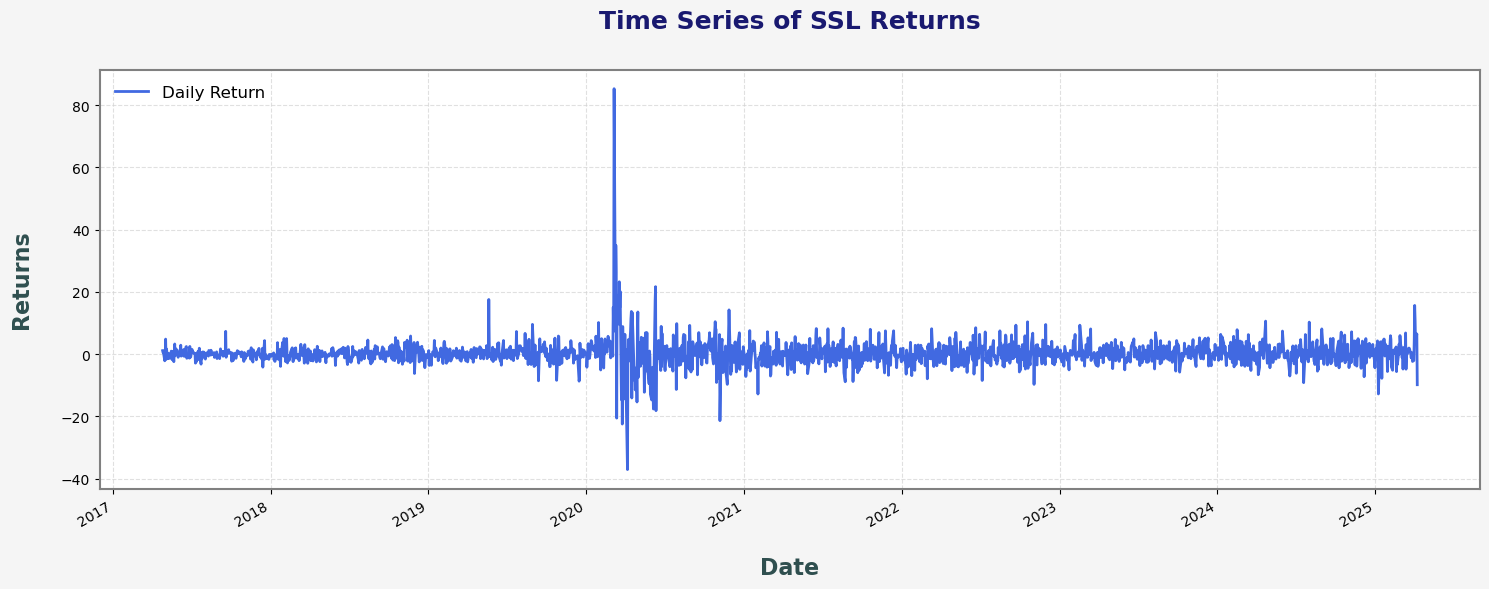

In [65]:
# Creating another time series line plot for y_ssl
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Plot y_ssl (SSL returns) on ax with some styling
y_ssl.plot(ax=ax, label="Daily Return", color='royalblue', linewidth=2)

# Add axis labels with improved styling
plt.xlabel("Date", fontsize=16, color='darkslategray', labelpad=20, fontweight='bold')
plt.ylabel("Returns", fontsize=16, color='darkslategray', labelpad=20, fontweight='bold')

# Add title with elegant styling
plt.title("Time Series of SSL Returns", fontsize=18, fontweight='bold', color='midnightblue', pad=30)

# Add grid with a soft, subtle style
plt.grid(True, linestyle='--', color='lightgray', alpha=0.7)

# Add legend for clarity
plt.legend(fontsize=12, loc='upper left', frameon=False)

# Set background color for the plot
fig.patch.set_facecolor('whitesmoke')

# Add a border for a clean finish
ax.spines['top'].set_linewidth(1.5)
ax.spines['top'].set_color('gray')
ax.spines['right'].set_linewidth(1.5)
ax.spines['right'].set_color('gray')

ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['bottom'].set_color('gray')

# Improve layout for tight spacing
plt.tight_layout()

# Show the plot
plt.show()

This graph displays the time series of returns for SSL, showing significant volatility with a notable spike around 2020. The returns fluctuate around zero, indicating periods of both gains and losses, with the most extreme movements during the 2020 spike.

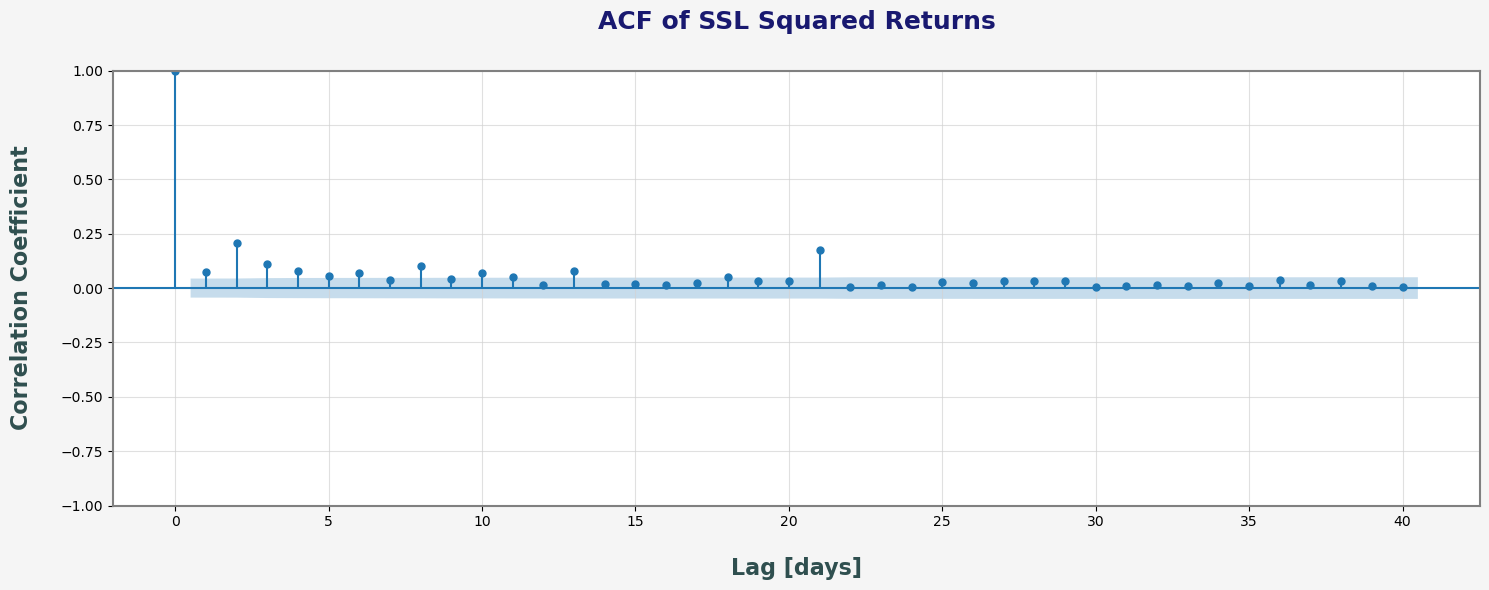

In [63]:
# Also we create an ACF plot of the squared returns for SSL.
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_ssl**2, ax=ax, lags=40)  # You can adjust the number of lags as needed

# Add axis labels with improved style
plt.xlabel("Lag [days]", fontsize=16, color='darkslategray', labelpad=20, fontweight='bold')
plt.ylabel("Correlation Coefficient", fontsize=16, color='darkslategray', labelpad=20, fontweight='bold')

# Add title with elegant font style
plt.title("ACF of SSL Squared Returns", fontsize=18, fontweight='bold', color='midnightblue', pad=30)

# Add grid with soft transparency and styling
plt.grid(True, linestyle='-', color='lightgray', alpha=0.7)

# Set background color for the plot
fig.patch.set_facecolor('whitesmoke')

# Add a border around the plot for a more polished look
ax.spines['top'].set_linewidth(1.5)
ax.spines['top'].set_color('gray')
ax.spines['right'].set_linewidth(1.5)
ax.spines['right'].set_color('gray')

ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['bottom'].set_color('gray')

# Improve layout for tight spacing
plt.tight_layout()

# Show the plot
plt.show()


This plot shows the Autocorrelation Function (ACF) of the squared returns of SSL, identifying patterns in volatility over different time lags up to 35 days. The significant spike at lag 0 and smaller spikes at other lags suggest some persistence in volatility, with most values falling within the confidence interval.

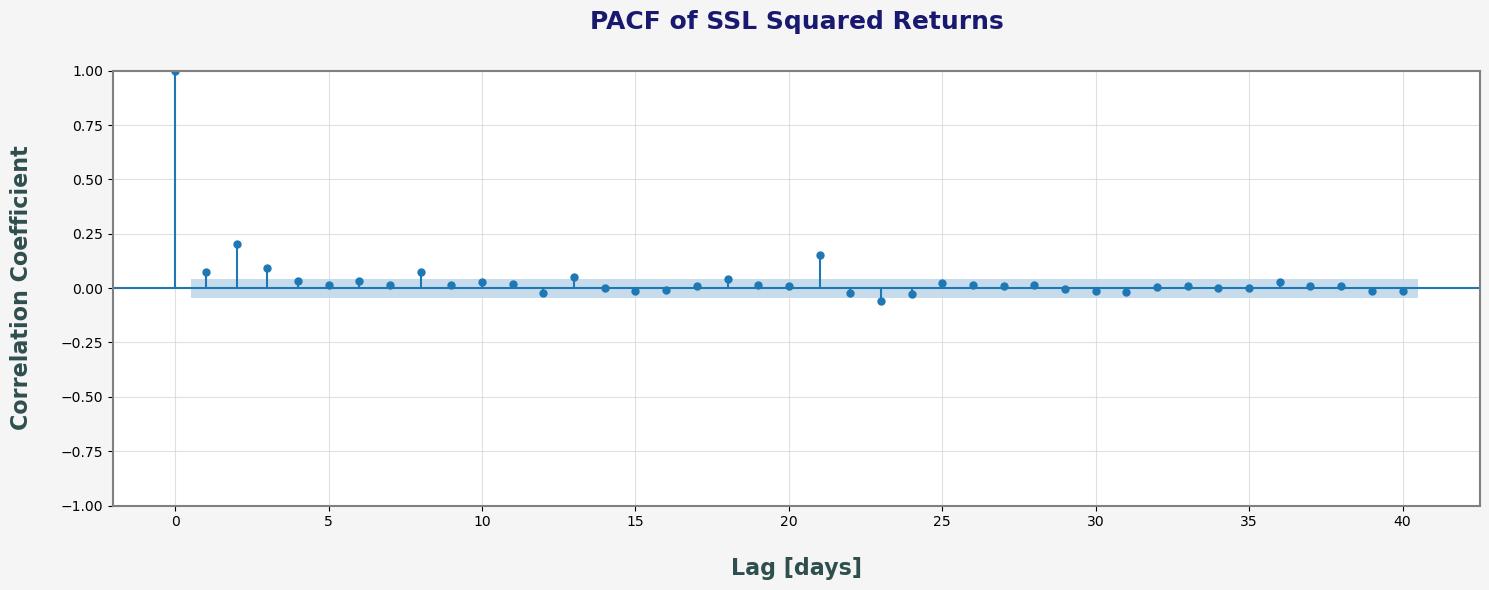

In [61]:
# And also create a PACF plot of the squared returns for SSL.
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y_ssl**2, ax=ax, lags=40)  # You can adjust the number of lags as needed

# Add axis labels with improved style
plt.xlabel("Lag [days]", fontsize=16, color='darkslategray', labelpad=20, fontweight='bold')
plt.ylabel("Correlation Coefficient", fontsize=16, color='darkslategray', labelpad=20, fontweight='bold')

# Add title with elegant font style
plt.title("PACF of SSL Squared Returns", fontsize=18, fontweight='bold', color='midnightblue', pad=30)

# Add grid with soft transparency and styling
plt.grid(True, linestyle='-', color='lightgray', alpha=0.7)

# Set background color for the plot
fig.patch.set_facecolor('whitesmoke')

# Add a border around the plot for a more polished look
ax.spines['top'].set_linewidth(1.5)
ax.spines['top'].set_color('gray')
ax.spines['right'].set_linewidth(1.5)
ax.spines['right'].set_color('gray')

ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['bottom'].set_color('gray')

# Improve layout for tight spacing
plt.tight_layout()

# Show the plot
plt.show()


The Partial Autocorrelation Function (PACF) plot of SSL squared returns isolates direct correlations at each lag, with significant spikes at lag 0 and around lag 20. Most lags show correlations close to zero, indicating that volatility clustering may not be strongly persistent beyond a few time steps.

Okay now we have explored and now we create a training set y_ssl_train that contains the first 80% of the observations in y_ssl.

In [33]:
cutoff_test = int(len(y_ssl)*0.8)
y_ssl_train = y_ssl.iloc[:cutoff_test]
y_ssl_train.head()

date
2017-04-26    1.108575
2017-04-27    0.491481
2017-04-28    0.493908
2017-05-01   -2.158505
2017-05-02   -0.257069
Name: return, dtype: float64

Now, we construct and fit a GARCH model using the data in y_ssl. By testing various values for p and q, we evaluate its performance through the summary.

In the context of a GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model:

p refers to the order of the ARCH (Autoregressive Conditional Heteroskedasticity) term. It determines how many past values of the squared residuals (errors) are included to model the conditional variance.

q refers to the order of the GARCH term. It specifies how many past values of the estimated conditional variance are used to model the current variance.

So, the GARCH(p, q) model includes both past error terms (ARCH) and past variance estimates (GARCH) to forecast future volatility or conditional variance. You can tune the values of p and q to find the best fit for your data.

In [55]:
# Build and train model
model = arch_model(
    y_ssl_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)
print("model type:", type(model))

# Show model summary
model.summary

model type: <class 'arch.univariate.base.ARCHModelResult'>


<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4076.47
Distribution:                  Normal   AIC:                           8160.93
Method:            Maximum Likelihood   BIC:                           8182.44
                                        No. Observations:                 1600
Date:                Thu, Apr 10 2025   Df Residuals:                     1599
Time:                        16:14:26   Df Model:                            1
                                Mean Model                               
                  coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------------------------------------------------
mu         -4.8395e-03  6.

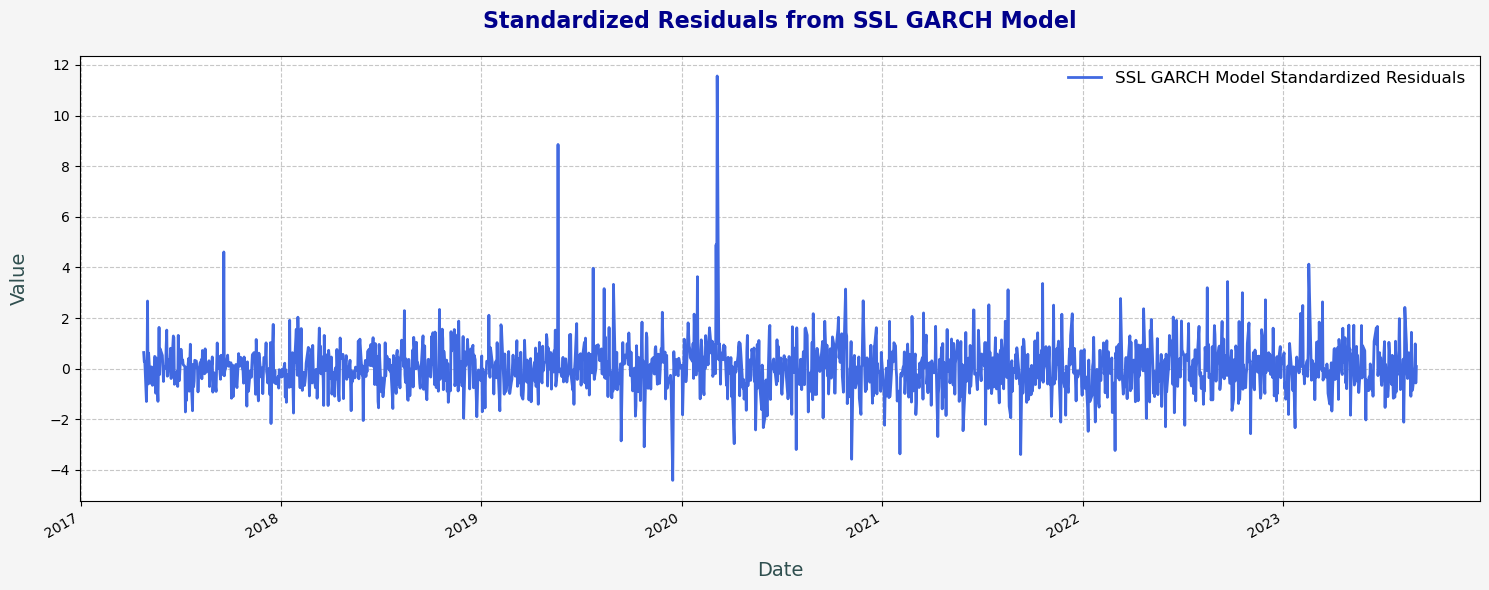

In [57]:
# Now we plot the standardized residuals for our model
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals with style (ensure 'model' is fitted before this step)
model.std_resid.plot(ax=ax, label="SSL GARCH Model Standardized Residuals", color='royalblue', linewidth=2)

# Add axis labels with style
plt.xlabel("Date", fontsize=14, color='darkslategray', labelpad=15)
plt.ylabel("Value", fontsize=14, color='darkslategray', labelpad=15)

# Add title with style
plt.title("Standardized Residuals from SSL GARCH Model", fontsize=16, fontweight='bold', color='darkblue', pad=20)

# Add grid with transparency
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend with improved style
plt.legend(fontsize=12, loc='upper right', frameon=False)

# Set background color
fig.patch.set_facecolor('whitesmoke')

# Show the plot
plt.tight_layout()
plt.show()

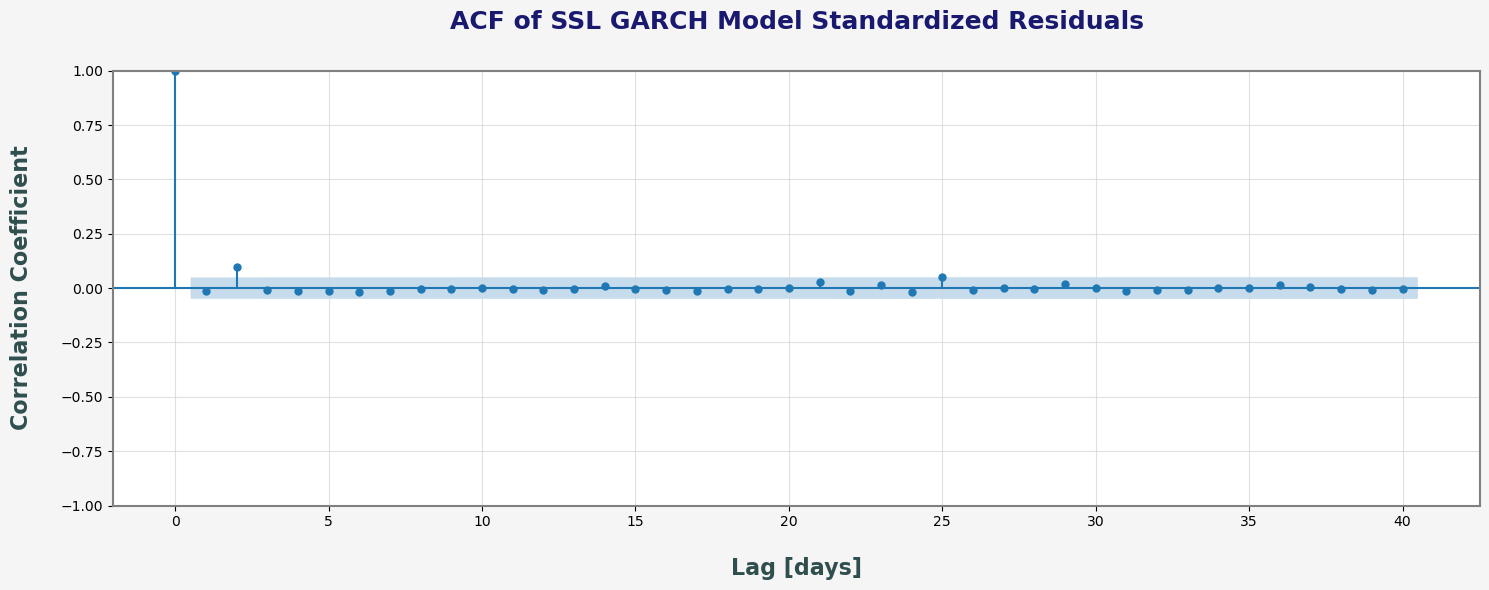

In [59]:
# we also create an ACF plot of the squared, standardized residuals of our model

fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax, lags=40)

# Add axis labels with improved style
plt.xlabel("Lag [days]", fontsize=16, color='darkslategray', labelpad=20, fontweight='bold')
plt.ylabel("Correlation Coefficient", fontsize=16, color='darkslategray', labelpad=20, fontweight='bold')

# Add title with elegant font style
plt.title("ACF of SSL GARCH Model Standardized Residuals", fontsize=18, fontweight='bold', color='midnightblue', pad=30)

# Add grid with soft transparency and styling
plt.grid(True, linestyle='-', color='lightgray', alpha=0.7)

# Set background color for the plot
fig.patch.set_facecolor('whitesmoke')

# Add a border around the plot for a more polished look
ax.spines['top'].set_linewidth(1.5)
ax.spines['top'].set_color('gray')
ax.spines['right'].set_linewidth(1.5)
ax.spines['right'].set_color('gray')

ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['bottom'].set_color('gray')

# Improve layout for tight spacing
plt.tight_layout()

# Show the plot
plt.show()


Conclusion
In this project, we successfully developed a model to predict the stock volatility of Sasol Limited (SSL) using a GARCH model. Through the analysis of SSL's stock returns, we identified a significant spike in volatility in early 2020, likely driven by the global uncertainty caused by the COVID-19 pandemic. This spike was followed by a stabilization period, where volatility remained relatively steady, fluctuating between 50% and 70% annually.

The GARCH model effectively captured these volatility trends, showing how past volatility and errors contribute to current market conditions. By segmenting the data and tuning the model, we were able to forecast future volatility, providing useful insights for potential investment strategies.

Going forward, this model could be refined with more advanced techniques, such as EGARCH, or by incorporating additional external variables like oil prices or market indices. With further optimization, this model could become a valuable tool for predicting market risk and aiding investment decision-making.